# Bidirectional Multi-Scale Pyramid Motion Detection

This notebook implements **bidirectional multi-scale pyramid processing** for motion detection, extending the RANSAC-based approach to handle objects of ALL sizes without manual parameter tuning.

## Problem
Fixed hyperparameters at a single scale fail for:
- **Very small objects**: Get filtered out by morphology or fall below min area threshold
- **Small objects**: Weak signal may not pass threshold
- **Large objects**: May be split into multiple detections or exceed max area

## Solution: Bidirectional Pyramid
Process residuals at multiple scales in BOTH directions:

### Upscale Pyramid (for small objects)
- **2.0x scale**: Very small objects become 4x larger in pixel area
- **1.5x scale**: Small objects become 2.25x larger

### Original Scale
- **1.0x scale**: Medium objects detected with base parameters

### Downscale Pyramid (for large objects)
- **0.5x scale**: Large objects fit better within detection parameters
- **0.25x scale**: Very large objects can be detected as single units

All detections are scaled back to original coordinates and merged using NMS to eliminate duplicates.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [2]:
# Configuration
VIDEO_PATH = 'data/videos/heli_1.mp4'
OUTPUT_DIR = 'data/multiscale_motion_frames'
PYRAMID_DIR = 'data/multiscale_pyramid_frames'
DEBUG_DIR = 'data/debug_frames'  # Directory for debug output

# ==============================================
# DEBUG MODE - Save intermediate processing steps
# ==============================================
DEBUG = True  # Set to True to save all intermediate processing steps

# Create output directories
for dir_path in [OUTPUT_DIR, PYRAMID_DIR, DEBUG_DIR]:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

# Feature detection parameters (Shi-Tomasi)
feature_params = dict(
    maxCorners=400,
    qualityLevel=0.01,
    minDistance=15,
    blockSize=7
)

# Lucas-Kanade optical flow parameters
lk_params = dict(
    winSize=(19, 19),
    maxLevel=3,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)
)

# RANSAC parameters
RANSAC_REPROJ_THRESHOLD = 3.0

# ==============================================
# BIDIRECTIONAL PYRAMID PARAMETERS
# ==============================================

# Upscale levels (for SMALL object detection)
# At higher resolution, small objects become larger and easier to detect
UPSCALE_FACTORS = [1.5, 2.0]  # 1.5x and 2x upscaling

# Downscale levels (for LARGE object detection)  
# At lower resolution, large objects fit better within detection parameters
NUM_DOWNSCALE_LEVELS = 2  # 0.5x, 0.25x
DOWNSCALE_FACTOR = 0.5

# Base parameters (for original 1.0x scale)
BASE_THRESHOLD_SIGMA = 3.0
BASE_MORPH_KERNEL_SIZE = 3
BASE_MIN_AREA = 100
BASE_MAX_AREA = 50000

# Scale adjustment factors for DOWNSCALE levels (scale < 1.0)
DOWNSCALE_THRESHOLD_FACTOR = 1.3  # Threshold increases (less sensitive)
DOWNSCALE_KERNEL_INCREMENT = 2    # Kernel grows by 2 each level

# Scale adjustment factors for UPSCALE levels (scale > 1.0)
UPSCALE_THRESHOLD_FACTOR = 0.85   # Threshold decreases (more sensitive)
UPSCALE_KERNEL_SIZE = 3           # Keep small kernel for fine details

# Valid mask parameters
BORDER_MARGIN = 20

# Sampling
FRAME_SAMPLE_INTERVAL = 2

In [3]:
# ============================================
# Base functions (same as RANSAC approach)
# ============================================

def detect_features(gray):
    """Detect Shi-Tomasi features for tracking."""
    pts = cv2.goodFeaturesToTrack(gray, **feature_params)
    return pts


def track_features(prev_gray, curr_gray, prev_pts):
    """Track features using Lucas-Kanade optical flow."""
    if prev_pts is None or len(prev_pts) == 0:
        return None, None, None
    
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(
        prev_gray, curr_gray, prev_pts, None, **lk_params
    )
    
    if status is not None:
        good_old = prev_pts[status.ravel() == 1]
        good_new = curr_pts[status.ravel() == 1]
        return good_old, good_new, status
    
    return None, None, None


def estimate_ego_motion_ransac(old_pts, new_pts):
    """Estimate camera ego-motion using RANSAC homography."""
    if old_pts is None or len(old_pts) < 4:
        return None, None
    
    H, inlier_mask = cv2.findHomography(
        old_pts, new_pts, cv2.RANSAC, RANSAC_REPROJ_THRESHOLD
    )
    return H, inlier_mask


def warp_frame(frame, H):
    """Warp frame using homography."""
    h, w = frame.shape[:2]
    warped = cv2.warpPerspective(frame, H, (w, h))
    return warped


def create_valid_warp_mask(warped_frame, border_margin=20):
    """Create mask of valid pixels after warping."""
    if len(warped_frame.shape) == 3:
        valid_mask = cv2.cvtColor(warped_frame, cv2.COLOR_BGR2GRAY) > 0
    else:
        valid_mask = warped_frame > 0
    
    valid_mask = valid_mask.astype(np.uint8) * 255
    
    # Erode to avoid edge artifacts
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    valid_mask = cv2.erode(valid_mask, erode_kernel)
    
    # Exclude borders
    if border_margin > 0:
        valid_mask[:border_margin, :] = 0
        valid_mask[-border_margin:, :] = 0
        valid_mask[:, :border_margin] = 0
        valid_mask[:, -border_margin:] = 0
    
    return valid_mask


def compute_residual(curr_gray, warped_prev_gray, valid_mask=None):
    """Compute residual after ego-motion compensation."""
    residual = cv2.absdiff(curr_gray, warped_prev_gray)
    
    if valid_mask is not None:
        residual = cv2.bitwise_and(residual, residual, mask=valid_mask)
    
    return residual

In [4]:
# ============================================
# Debug Functions - Save intermediate steps
# ============================================

def save_debug_image(image, filename, frame_num, step_name, is_mask=False):
    """
    Save a debug image with proper formatting.
    
    Args:
        image: Image to save (grayscale or BGR)
        filename: Base filename
        frame_num: Current frame number
        step_name: Name of the processing step
        is_mask: If True, save as binary mask visualization
    """
    if not DEBUG:
        return
    
    # Create frame-specific directory
    frame_dir = Path(DEBUG_DIR) / f"frame_{frame_num:04d}"
    frame_dir.mkdir(parents=True, exist_ok=True)
    
    filepath = frame_dir / f"{filename}.png"
    
    if is_mask:
        # For masks, apply colormap for better visualization
        if len(image.shape) == 2:
            colored = cv2.applyColorMap(image, cv2.COLORMAP_JET)
            cv2.imwrite(str(filepath), colored)
        else:
            cv2.imwrite(str(filepath), image)
    else:
        cv2.imwrite(str(filepath), image)
    
    return str(filepath)


def draw_tracked_features(frame, old_pts, new_pts, inlier_mask=None):
    """
    Draw tracked features with motion vectors.
    Green = inliers (background motion)
    Red = outliers (potential moving objects)
    """
    output = frame.copy()
    
    if old_pts is None or new_pts is None:
        return output
    
    for i, (old, new) in enumerate(zip(old_pts, new_pts)):
        old_pt = tuple(map(int, old.ravel()))
        new_pt = tuple(map(int, new.ravel()))
        
        # Determine if inlier or outlier
        if inlier_mask is not None and i < len(inlier_mask):
            is_inlier = inlier_mask[i]
            color = (0, 255, 0) if is_inlier else (0, 0, 255)  # Green=inlier, Red=outlier
        else:
            color = (0, 255, 0)
        
        # Draw motion vector
        cv2.arrowedLine(output, old_pt, new_pt, color, 1, tipLength=0.3)
        cv2.circle(output, new_pt, 3, color, -1)
    
    return output


def save_pyramid_level_debug(residual_scaled, valid_mask_scaled, motion_mask_raw, 
                              motion_mask_morph, detections, scale, frame_num, params):
    """
    Save debug images for a single pyramid level.
    """
    if not DEBUG:
        return
    
    frame_dir = Path(DEBUG_DIR) / f"frame_{frame_num:04d}" / f"scale_{scale:.2f}x"
    frame_dir.mkdir(parents=True, exist_ok=True)
    
    # 1. Scaled residual
    cv2.imwrite(str(frame_dir / "1_residual_scaled.png"), residual_scaled)
    
    # 2. Valid mask at this scale
    if valid_mask_scaled is not None:
        cv2.imwrite(str(frame_dir / "2_valid_mask.png"), valid_mask_scaled)
    
    # 3. Raw thresholded mask (before morphology)
    colored_raw = cv2.applyColorMap(motion_mask_raw, cv2.COLORMAP_HOT)
    cv2.imwrite(str(frame_dir / "3_threshold_mask_raw.png"), colored_raw)
    
    # 4. Motion mask after morphology
    colored_morph = cv2.applyColorMap(motion_mask_morph, cv2.COLORMAP_HOT)
    cv2.imwrite(str(frame_dir / "4_motion_mask_morph.png"), colored_morph)
    
    # 5. Detections visualization at this scale
    h, w = residual_scaled.shape[:2]
    det_vis = np.zeros((h, w, 3), dtype=np.uint8)
    det_vis[:, :, 0] = residual_scaled  # Blue channel = residual
    
    for det in detections:
        x, y, bw, bh = det['bbox']
        cv2.rectangle(det_vis, (x, y), (x + bw, y + bh), (0, 255, 0), 2)
        cv2.circle(det_vis, det['centroid'], 4, (0, 0, 255), -1)
    
    cv2.imwrite(str(frame_dir / "5_detections.png"), det_vis)
    
    # 6. Save parameters as text file
    with open(str(frame_dir / "params.txt"), 'w') as f:
        f.write(f"Scale: {scale}x\n")
        f.write(f"Shape: {residual_scaled.shape}\n")
        f.write(f"Kernel size: {params['kernel_size']}\n")
        f.write(f"Threshold sigma: {params['threshold_sigma']:.2f}\n")
        f.write(f"Min area: {params['min_area']}\n")
        f.write(f"Max area: {params['max_area']}\n")
        f.write(f"Detections: {len(detections)}\n")


def save_frame_debug_summary(frame_num, curr_frame, prev_frame, warped_prev, 
                              valid_mask, residual, old_pts, new_pts, 
                              inlier_mask, detections, level_info):
    """
    Save a complete debug summary for a frame.
    """
    if not DEBUG:
        return
    
    frame_dir = Path(DEBUG_DIR) / f"frame_{frame_num:04d}"
    frame_dir.mkdir(parents=True, exist_ok=True)
    
    # 1. Original current frame
    cv2.imwrite(str(frame_dir / "01_current_frame.png"), curr_frame)
    
    # 2. Previous frame
    cv2.imwrite(str(frame_dir / "02_previous_frame.png"), prev_frame)
    
    # 3. Tracked features with motion vectors
    features_vis = draw_tracked_features(curr_frame, old_pts, new_pts, 
                                          inlier_mask.ravel() if inlier_mask is not None else None)
    cv2.imwrite(str(frame_dir / "03_tracked_features.png"), features_vis)
    
    # 4. Warped previous frame
    warped_vis = cv2.cvtColor(warped_prev, cv2.COLOR_GRAY2BGR) if len(warped_prev.shape) == 2 else warped_prev
    cv2.imwrite(str(frame_dir / "04_warped_previous.png"), warped_vis)
    
    # 5. Valid warp mask
    cv2.imwrite(str(frame_dir / "05_valid_mask.png"), valid_mask)
    
    # 6. Residual (grayscale)
    cv2.imwrite(str(frame_dir / "06_residual_gray.png"), residual)
    
    # 7. Residual (heatmap)
    residual_colored = cv2.applyColorMap(residual, cv2.COLORMAP_HOT)
    cv2.imwrite(str(frame_dir / "07_residual_heatmap.png"), residual_colored)
    
    # 8. Final detections on original frame
    final_output = draw_detections(curr_frame, detections)
    cv2.imwrite(str(frame_dir / "08_final_detections.png"), final_output)
    
    # 9. Summary text file
    with open(str(frame_dir / "summary.txt"), 'w') as f:
        f.write(f"Frame: {frame_num}\n")
        f.write(f"Tracked points: {len(old_pts) if old_pts is not None else 0}\n")
        f.write(f"Inliers: {np.sum(inlier_mask) if inlier_mask is not None else 0}\n")
        f.write(f"Total detections: {len(detections)}\n")
        f.write(f"\nPyramid levels processed: {len(level_info)}\n")
        for info in level_info:
            scale_type = "UPSCALE" if info['scale'] > 1.0 else ("ORIGINAL" if info['scale'] == 1.0 else "DOWNSCALE")
            f.write(f"  {info['scale']:.2f}x ({scale_type}): {info['detections']} detections\n")
        f.write(f"\nDetections by scale:\n")
        for det in detections:
            f.write(f"  Scale {det.get('scale', 1.0):.2f}x: bbox={det['bbox']}, area={det['area']}\n")
    
    # 10. Create composite overview image
    create_debug_composite(frame_num, frame_dir, curr_frame, warped_prev, 
                           residual, valid_mask, detections, level_info)


def create_debug_composite(frame_num, frame_dir, curr_frame, warped_prev, 
                           residual, valid_mask, detections, level_info):
    """
    Create a single composite image showing all key steps.
    """
    if not DEBUG:
        return
    
    h, w = curr_frame.shape[:2]
    
    # Resize all images to consistent size for composite
    thumb_h, thumb_w = 360, 640
    
    def resize_for_composite(img, is_gray=False):
        if is_gray and len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        return cv2.resize(img, (thumb_w, thumb_h))
    
    # Prepare thumbnails
    thumb_curr = resize_for_composite(curr_frame)
    thumb_warped = resize_for_composite(warped_prev, is_gray=True)
    thumb_residual = resize_for_composite(cv2.applyColorMap(residual, cv2.COLORMAP_HOT))
    thumb_mask = resize_for_composite(cv2.applyColorMap(valid_mask, cv2.COLORMAP_BONE))
    thumb_final = resize_for_composite(draw_detections(curr_frame, detections))
    
    # Create pyramid composite (show first 3 levels)
    pyramid_thumbs = []
    for i, info in enumerate(level_info[:3]):
        mask_colored = cv2.applyColorMap(info['mask'], cv2.COLORMAP_HOT)
        # Resize to same thumb size
        mask_resized = cv2.resize(mask_colored, (thumb_w, thumb_h))
        # Add scale label
        cv2.putText(mask_resized, f"{info['scale']:.2f}x", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        pyramid_thumbs.append(mask_resized)
    
    # Fill remaining slots if less than 3 levels
    while len(pyramid_thumbs) < 3:
        pyramid_thumbs.append(np.zeros((thumb_h, thumb_w, 3), dtype=np.uint8))
    
    # Create 3x3 grid
    row1 = np.hstack([thumb_curr, thumb_warped, thumb_residual])
    row2 = np.hstack([thumb_mask, thumb_final, pyramid_thumbs[0]])
    row3 = np.hstack([pyramid_thumbs[1], pyramid_thumbs[2], 
                      np.zeros((thumb_h, thumb_w, 3), dtype=np.uint8)])
    
    # Add labels
    font = cv2.FONT_HERSHEY_SIMPLEX
    labels = [
        ("Current Frame", 10, 25),
        ("Warped Previous", thumb_w + 10, 25),
        ("Residual", 2 * thumb_w + 10, 25),
    ]
    for label, x, y in labels:
        cv2.putText(row1, label, (x, y), font, 0.7, (0, 255, 0), 2)
    
    labels2 = [
        ("Valid Mask", 10, 25),
        (f"Final: {len(detections)} detections", thumb_w + 10, 25),
        ("Pyramid Level 0", 2 * thumb_w + 10, 25),
    ]
    for label, x, y in labels2:
        cv2.putText(row2, label, (x, y), font, 0.7, (0, 255, 0), 2)
    
    composite = np.vstack([row1, row2, row3])
    
    # Add frame number header
    cv2.putText(composite, f"Frame {frame_num} - Debug Overview", (10, composite.shape[0] - 10),
                font, 1.0, (255, 255, 255), 2)
    
    cv2.imwrite(str(frame_dir / "00_COMPOSITE_OVERVIEW.png"), composite)

In [5]:
# ============================================
# Bidirectional Multi-Scale Pyramid Functions
# ============================================

def build_bidirectional_pyramid(image, upscale_factors=UPSCALE_FACTORS, 
                                 num_downscale_levels=NUM_DOWNSCALE_LEVELS,
                                 downscale_factor=DOWNSCALE_FACTOR):
    """
    Build bidirectional pyramid with both upscaled and downscaled levels.
    
    Returns:
        List of (scale_factor, scaled_image) tuples, sorted by scale descending.
        
    Example output for upscale_factors=[1.5, 2.0], num_downscale_levels=3:
        [(2.0, upscaled_2x), (1.5, upscaled_1.5x), (1.0, original),
         (0.5, downscaled), (0.25, downscaled), (0.125, downscaled)]
    """
    pyramid = []
    
    # Add upscaled levels (for small object detection)
    for scale in sorted(upscale_factors, reverse=True):
        if scale > 1.0:
            new_size = (int(image.shape[1] * scale), int(image.shape[0] * scale))
            # Use INTER_CUBIC for quality upscaling (INTER_LANCZOS4 is slower but higher quality)
            scaled = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)
            pyramid.append((scale, scaled))
    
    # Add original scale (1.0x)
    pyramid.append((1.0, image))
    
    # Add downscaled levels (for large object detection)
    current = image
    current_scale = 1.0
    for i in range(num_downscale_levels):
        current_scale *= downscale_factor
        current = cv2.pyrDown(current)
        pyramid.append((current_scale, current))
    
    return pyramid


def get_bidirectional_scale_params(scale):
    """
    Get scale-normalized parameters for any pyramid level.
    
    For upscaled levels (scale > 1.0):
        - Keep small kernel (fine details matter)
        - Increase area thresholds (objects appear larger)
        - Slightly decrease threshold sigma (more sensitive)
    
    For downscaled levels (scale < 1.0):
        - Increase kernel size (noise is relatively larger)
        - Decrease area thresholds (objects appear smaller)
        - Increase threshold sigma (less sensitive)
    """
    if scale > 1.0:
        # UPSCALE parameters
        # Objects appear larger, so area thresholds increase quadratically
        area_scale = scale ** 2
        
        # Keep kernel small for fine detail detection
        kernel_size = UPSCALE_KERNEL_SIZE
        
        # Be more sensitive at higher resolution
        # Each doubling of scale reduces sigma slightly
        scale_steps = np.log2(scale)  # 1.5x ≈ 0.58 steps, 2.0x = 1 step
        threshold_sigma = BASE_THRESHOLD_SIGMA * (UPSCALE_THRESHOLD_FACTOR ** scale_steps)
        
        # Area thresholds scale up quadratically
        min_area = int(BASE_MIN_AREA * area_scale)
        max_area = int(BASE_MAX_AREA * area_scale)
        
    elif scale < 1.0:
        # DOWNSCALE parameters
        # Calculate how many levels down (0.5 = 1 level, 0.25 = 2 levels, etc.)
        level = int(np.log2(1.0 / scale))
        
        # Kernel increases at coarser levels
        kernel_size = BASE_MORPH_KERNEL_SIZE + (DOWNSCALE_KERNEL_INCREMENT * level)
        
        # Threshold increases (less sensitive)
        threshold_sigma = BASE_THRESHOLD_SIGMA * (DOWNSCALE_THRESHOLD_FACTOR ** level)
        
        # Area thresholds scale down quadratically
        area_scale = scale ** 2
        min_area = max(10, int(BASE_MIN_AREA * area_scale))
        max_area = max(100, int(BASE_MAX_AREA * area_scale))
        
    else:
        # Original scale (1.0x) - base parameters
        kernel_size = BASE_MORPH_KERNEL_SIZE
        threshold_sigma = BASE_THRESHOLD_SIGMA
        min_area = BASE_MIN_AREA
        max_area = BASE_MAX_AREA
    
    # Ensure odd kernel size
    if kernel_size % 2 == 0:
        kernel_size += 1
    
    return {
        'scale': scale,
        'threshold_sigma': threshold_sigma,
        'kernel_size': kernel_size,
        'min_area': min_area,
        'max_area': max_area
    }


def adaptive_threshold_mad(residual, valid_mask=None, sigma_multiplier=3.0):
    """
    Adaptive thresholding using Median Absolute Deviation (MAD).
    More robust to outliers than mean/std.
    """
    if valid_mask is not None:
        valid_pixels = residual[valid_mask > 0]
    else:
        valid_pixels = residual.ravel()
    
    if len(valid_pixels) == 0:
        return np.zeros_like(residual, dtype=np.uint8), 15.0
    
    median_val = np.median(valid_pixels)
    mad = np.median(np.abs(valid_pixels.astype(np.float32) - median_val))
    mad_std = mad * 1.4826  # Scale factor for normal distribution
    
    threshold = median_val + sigma_multiplier * mad_std
    threshold = max(threshold, 15)  # Minimum threshold
    
    _, motion_mask = cv2.threshold(
        residual, threshold, 255, cv2.THRESH_BINARY
    )
    
    if valid_mask is not None:
        motion_mask = cv2.bitwise_and(motion_mask, motion_mask, mask=valid_mask)
    
    return motion_mask.astype(np.uint8), threshold


def morphological_cleanup(mask, kernel_size=5):
    """
    Apply morphological operations with specified kernel size.
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    
    # Close - fill small holes
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # Open - remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mask


def extract_bounding_boxes(mask, min_area=100, max_area=50000):
    """
    Extract bounding boxes using connected components.
    """
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    
    detections = []
    for i in range(1, num_labels):  # Skip background (0)
        area = stats[i, cv2.CC_STAT_AREA]
        
        if min_area < area < max_area:
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            centroid = tuple(map(int, centroids[i]))
            
            detections.append({
                'bbox': (x, y, w, h),
                'centroid': centroid,
                'area': area
            })
    
    return detections


def process_pyramid_level(residual_scaled, valid_mask, scale, frame_num=None):
    """
    Process a single pyramid level with scale-appropriate parameters.
    Returns detections at that scale (coordinates in that scale's space).
    
    If frame_num is provided and DEBUG=True, saves intermediate debug images.
    """
    params = get_bidirectional_scale_params(scale)
    
    # Scale valid mask to match residual size at this level
    if valid_mask is not None:
        h, w = residual_scaled.shape[:2]
        valid_mask_scaled = cv2.resize(valid_mask, (w, h), interpolation=cv2.INTER_NEAREST)
    else:
        valid_mask_scaled = None
    
    # Threshold with scale-adjusted sigma
    motion_mask_raw, thresh_val = adaptive_threshold_mad(
        residual_scaled, valid_mask_scaled, params['threshold_sigma']
    )
    
    # Morphological cleanup with scale-adjusted kernel
    motion_mask = morphological_cleanup(motion_mask_raw, params['kernel_size'])
    
    # Extract detections with scale-adjusted area thresholds
    detections = extract_bounding_boxes(
        motion_mask, params['min_area'], params['max_area']
    )
    
    # Save debug images for this pyramid level
    if DEBUG and frame_num is not None:
        save_pyramid_level_debug(
            residual_scaled, valid_mask_scaled, motion_mask_raw,
            motion_mask, detections, scale, frame_num, params
        )
    
    return detections, motion_mask, thresh_val, params


def scale_detections_to_original(detections, scale):
    """
    Scale detections from pyramid level coordinates to original image coordinates.
    Works for both upscaled (scale > 1) and downscaled (scale < 1) levels.
    """
    if scale == 1.0:
        # No scaling needed, just add scale info
        for det in detections:
            det['scale'] = scale
        return detections
    
    # Scale factor to convert back to original coordinates
    inv_scale = 1.0 / scale
    
    scaled_detections = []
    for det in detections:
        x, y, w, h = det['bbox']
        cx, cy = det['centroid']
        
        scaled_detections.append({
            'bbox': (
                int(x * inv_scale),
                int(y * inv_scale),
                int(w * inv_scale),
                int(h * inv_scale)
            ),
            'centroid': (int(cx * inv_scale), int(cy * inv_scale)),
            'area': int(det['area'] * inv_scale * inv_scale),
            'scale': scale
        })
    
    return scaled_detections


def merge_overlapping_detections(all_detections, iou_threshold=0.3):
    """
    Merge overlapping detections from different pyramid levels.
    Uses Non-Maximum Suppression (NMS) based on IoU.
    Prefers detections from scales closer to 1.0 (more reliable).
    """
    if len(all_detections) == 0:
        return []
    
    # Convert to arrays for NMS
    boxes = []
    for det in all_detections:
        x, y, w, h = det['bbox']
        boxes.append([x, y, x + w, y + h])
    
    boxes = np.array(boxes, dtype=np.float32)
    
    # Score: prefer scales closer to 1.0, with area as tiebreaker
    # Score = area * (1 / abs(log2(scale) + 0.1))
    scores = []
    for det in all_detections:
        scale = det.get('scale', 1.0)
        scale_penalty = abs(np.log2(scale)) + 0.1  # Closer to 1.0 = smaller penalty
        score = det['area'] / scale_penalty
        scores.append(score)
    
    scores = np.array(scores, dtype=np.float32)
    
    # Apply NMS
    indices = cv2.dnn.NMSBoxes(
        boxes.tolist(),
        scores.tolist(),
        score_threshold=0.0,
        nms_threshold=iou_threshold
    )
    
    # Handle different OpenCV versions
    if len(indices) > 0:
        if isinstance(indices[0], (list, np.ndarray)):
            indices = [i[0] for i in indices]
        merged = [all_detections[i] for i in indices]
    else:
        merged = []
    
    return merged


def process_bidirectional_pyramid(residual, valid_mask, 
                                   upscale_factors=UPSCALE_FACTORS,
                                   num_downscale_levels=NUM_DOWNSCALE_LEVELS,
                                   frame_num=None):
    """
    Main bidirectional multi-scale processing function.
    
    1. Build pyramid with upscaled AND downscaled levels
    2. Process each level with scale-appropriate parameters
    3. Scale detections back to original coordinates
    4. Merge overlapping detections across all scales
    
    Args:
        residual: Motion residual image
        valid_mask: Mask of valid pixels
        upscale_factors: List of upscale factors
        num_downscale_levels: Number of downscale levels
        frame_num: Frame number for debug output (optional)
    
    Returns:
        merged_detections: List of detection dicts with 'scale' indicating source level
        level_info: Debug info for each pyramid level
    """
    # Build bidirectional pyramid
    pyramid = build_bidirectional_pyramid(
        residual, upscale_factors, num_downscale_levels
    )
    
    all_detections = []
    level_info = []
    
    for scale, residual_scaled in pyramid:
        # Process this level (with debug output if frame_num provided)
        detections, mask, thresh, params = process_pyramid_level(
            residual_scaled, valid_mask, scale, frame_num
        )
        
        # Scale detections to original coordinates
        scaled_detections = scale_detections_to_original(detections, scale)
        all_detections.extend(scaled_detections)
        
        level_info.append({
            'scale': scale,
            'shape': residual_scaled.shape,
            'params': params,
            'threshold': thresh,
            'detections': len(detections),
            'mask': mask
        })
    
    # Merge overlapping detections from all scales
    merged_detections = merge_overlapping_detections(all_detections)
    
    return merged_detections, level_info


# Keep old function for backward compatibility
def build_pyramid(image, num_levels):
    """Legacy function - builds downscale-only pyramid."""
    pyramid = [image]
    current = image
    for i in range(1, num_levels):
        current = cv2.pyrDown(current)
        pyramid.append(current)
    return pyramid


def get_scale_params(level):
    """Legacy function - maps level index to scale and gets params."""
    scale = DOWNSCALE_FACTOR ** level
    return get_bidirectional_scale_params(scale)


def process_multiscale(residual, valid_mask, num_levels=3):
    """Legacy function - downscale-only processing."""
    return process_bidirectional_pyramid(
        residual, valid_mask, 
        upscale_factors=[],  # No upscaling
        num_downscale_levels=num_levels - 1  # -1 because level 0 is original
    )

In [6]:
# ============================================
# Visualization Functions
# ============================================

def get_scale_color(scale):
    """Get color based on scale factor."""
    if scale > 1.5:
        return (255, 0, 255)    # Magenta - 2x upscale (very small objects)
    elif scale > 1.0:
        return (255, 0, 0)      # Blue - 1.5x upscale (small objects)
    elif scale == 1.0:
        return (0, 255, 0)      # Green - original scale (medium objects)
    elif scale >= 0.5:
        return (0, 255, 255)    # Yellow - 0.5x downscale (large objects)
    else:
        return (0, 165, 255)    # Orange - 0.25x+ downscale (very large objects)


def draw_detections(frame, detections):
    """Draw bounding boxes with scale info."""
    output = frame.copy()
    
    for det in detections:
        x, y, w, h = det['bbox']
        scale = det.get('scale', 1.0)
        color = get_scale_color(scale)
        
        cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)
        cv2.circle(output, det['centroid'], 5, (0, 0, 255), -1)
        
        label = f"{scale:.1f}x A:{det['area']}"
        cv2.putText(output, label, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    return output


def visualize_pyramid_levels(level_info, save_path=None):
    """
    Visualize detection masks at each pyramid level.
    """
    num_levels = len(level_info)
    
    # Calculate grid layout
    cols = min(3, num_levels)
    rows = (num_levels + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows))
    
    if num_levels == 1:
        axes = np.array([axes])
    axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    
    for i, info in enumerate(level_info):
        ax = axes[i]
        ax.imshow(info['mask'], cmap='hot')
        
        scale = info['scale']
        scale_type = "UPSCALE" if scale > 1.0 else ("ORIGINAL" if scale == 1.0 else "DOWNSCALE")
        
        ax.set_title(
            f"Scale {scale:.2f}x ({scale_type})\n"
            f"Shape: {info['shape']}\n"
            f"Kernel: {info['params']['kernel_size']}, "
            f"σ: {info['params']['threshold_sigma']:.2f}\n"
            f"Area: [{info['params']['min_area']}, {info['params']['max_area']}]\n"
            f"Detections: {info['detections']}"
        )
        ax.axis('off')
    
    # Hide unused subplots
    for i in range(num_levels, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150)
    
    plt.show()


def print_pyramid_config():
    """Print current pyramid configuration."""
    print("=" * 60)
    print("BIDIRECTIONAL PYRAMID CONFIGURATION")
    print("=" * 60)
    
    all_scales = sorted(UPSCALE_FACTORS + [1.0] + 
                        [DOWNSCALE_FACTOR ** (i+1) for i in range(NUM_DOWNSCALE_LEVELS)],
                        reverse=True)
    
    print(f"\n{'Scale':<10} {'Type':<12} {'Kernel':<8} {'Sigma':<8} {'Min Area':<10} {'Max Area':<10}")
    print("-" * 60)
    
    for scale in all_scales:
        params = get_bidirectional_scale_params(scale)
        scale_type = "UPSCALE" if scale > 1.0 else ("ORIGINAL" if scale == 1.0 else "DOWNSCALE")
        print(f"{scale:<10.3f} {scale_type:<12} {params['kernel_size']:<8} "
              f"{params['threshold_sigma']:<8.2f} {params['min_area']:<10} {params['max_area']:<10}")
    
    print("=" * 60)

In [7]:
# ============================================
# Main Processing Pipeline
# ============================================

def process_video_bidirectional(video_path, 
                                 upscale_factors=UPSCALE_FACTORS,
                                 num_downscale_levels=NUM_DOWNSCALE_LEVELS,
                                 debug=DEBUG):
    """
    Process video with bidirectional multi-scale pyramid motion detection.
    
    Args:
        video_path: Path to input video
        upscale_factors: List of upscale factors for small object detection
        num_downscale_levels: Number of downscale levels for large object detection
        debug: If True, save intermediate processing steps as images
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return
    
    ret, prev_frame = cap.read()
    if not ret:
        print("Error: Cannot read first frame")
        return
    
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    prev_pts = detect_features(prev_gray)
    
    frame_count = 0
    saved_count = 0
    
    # Print configuration
    print_pyramid_config()
    print(f"\nProcessing video: {video_path}")
    print(f"Upscale factors: {upscale_factors}")
    print(f"Downscale levels: {num_downscale_levels}")
    print(f"DEBUG mode: {debug}")
    if debug:
        print(f"Debug output: {DEBUG_DIR}")
    print()
    
    # Track detections by scale for statistics
    scale_detection_counts = {}
    
    while True:
        ret, curr_frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
        
        # Track features
        old_pts, new_pts, status = track_features(prev_gray, curr_gray, prev_pts)
        
        if old_pts is not None and len(old_pts) >= 4:
            # Estimate ego-motion with RANSAC
            H, inlier_mask = estimate_ego_motion_ransac(old_pts, new_pts)
            
            if H is not None:
                # Warp previous frame
                warped_prev_gray = warp_frame(prev_gray, H)
                
                # Create valid mask
                valid_mask = create_valid_warp_mask(warped_prev_gray, BORDER_MARGIN)
                
                # Compute residual
                residual = compute_residual(curr_gray, warped_prev_gray, valid_mask)
                
                # Determine if we should save debug for this frame
                should_save_debug = debug and (frame_count % FRAME_SAMPLE_INTERVAL == 0)
                debug_frame_num = frame_count if should_save_debug else None
                
                # Bidirectional multi-scale processing
                detections, level_info = process_bidirectional_pyramid(
                    residual, valid_mask, upscale_factors, num_downscale_levels,
                    frame_num=debug_frame_num
                )
                
                # Save frames at intervals
                if frame_count % FRAME_SAMPLE_INTERVAL == 0:
                    # Draw results
                    output_frame = draw_detections(curr_frame, detections)
                    
                    # Save output frame
                    cv2.imwrite(
                        f"{OUTPUT_DIR}/frame_{saved_count:04d}.png",
                        output_frame
                    )
                    
                    # Save debug summary if DEBUG mode is enabled
                    if debug:
                        save_frame_debug_summary(
                            frame_count, curr_frame, prev_frame, warped_prev_gray,
                            valid_mask, residual, old_pts, new_pts,
                            inlier_mask, detections, level_info
                        )
                    
                    # Count detections per scale
                    scale_counts = {}
                    for det in detections:
                        scale = det.get('scale', 1.0)
                        scale_key = f"{scale:.2f}x"
                        scale_counts[scale_key] = scale_counts.get(scale_key, 0) + 1
                        scale_detection_counts[scale_key] = scale_detection_counts.get(scale_key, 0) + 1
                    
                    debug_str = " [DEBUG SAVED]" if debug else ""
                    print(f"Frame {frame_count}: {len(detections)} detections "
                          f"(by scale: {scale_counts}){debug_str}")
                    saved_count += 1
        
        # Re-detect features periodically
        if frame_count % 10 == 0 or (new_pts is not None and len(new_pts) < 50):
            prev_pts = detect_features(curr_gray)
        else:
            prev_pts = new_pts.reshape(-1, 1, 2) if new_pts is not None else detect_features(curr_gray)
        
        prev_frame = curr_frame.copy()
        prev_gray = curr_gray.copy()
    
    cap.release()
    
    print(f"\n{'=' * 60}")
    print("PROCESSING COMPLETE")
    print(f"{'=' * 60}")
    print(f"Saved {saved_count} frames to: {OUTPUT_DIR}")
    if debug:
        print(f"Debug output saved to: {DEBUG_DIR}")
    print(f"\nTotal detections by scale:")
    for scale, count in sorted(scale_detection_counts.items(), key=lambda x: float(x[0].replace('x', '')), reverse=True):
        print(f"  {scale}: {count}")


# Legacy function for backward compatibility
def process_video_multiscale(video_path, num_levels=6):
    """Legacy wrapper - uses downscale-only pyramid."""
    process_video_bidirectional(
        video_path,
        upscale_factors=[],
        num_downscale_levels=num_levels - 1,
        debug=DEBUG
    )

In [8]:
# Run the bidirectional multi-scale pipeline
# Set DEBUG=True in config cell to save all intermediate processing steps

process_video_bidirectional(
    VIDEO_PATH, 
    upscale_factors=UPSCALE_FACTORS,           # [1.5, 2.0, 2.5] for small objects
    num_downscale_levels=NUM_DOWNSCALE_LEVELS,  # 3 levels for large objects
    debug=DEBUG                                 # Save debug images if True
)

BIDIRECTIONAL PYRAMID CONFIGURATION

Scale      Type         Kernel   Sigma    Min Area   Max Area  
------------------------------------------------------------
2.000      UPSCALE      3        2.55     400        200000    
1.500      UPSCALE      3        2.73     225        112500    
1.000      ORIGINAL     3        3.00     100        50000     
0.500      DOWNSCALE    5        3.90     25         12500     
0.250      DOWNSCALE    7        5.07     10         3125      

Processing video: data/videos/heli_1.mp4
Upscale factors: [1.5, 2.0]
Downscale levels: 2
DEBUG mode: True
Debug output: data/debug_frames

Frame 2: 5 detections (by scale: {'1.00x': 5}) [DEBUG SAVED]
Frame 4: 6 detections (by scale: {'1.00x': 5, '2.00x': 1}) [DEBUG SAVED]
Frame 6: 7 detections (by scale: {'1.00x': 5, '2.00x': 1, '1.50x': 1}) [DEBUG SAVED]
Frame 8: 5 detections (by scale: {'1.00x': 5}) [DEBUG SAVED]
Frame 10: 1 detections (by scale: {'1.00x': 1}) [DEBUG SAVED]
Frame 12: 4 detections (by scale: {'


Frame 30 Analysis - Bidirectional Pyramid
Total detections (after NMS merging): 2

Per-scale breakdown:
  2.00x (UPSCALE): (928, 1696) -> 4 raw detections, threshold=15.0
  1.50x (UPSCALE): (696, 1272) -> 5 raw detections, threshold=15.0
  1.00x (ORIGINAL): (464, 848) -> 5 raw detections, threshold=15.0
  0.50x (DOWNSCALE): (232, 424) -> 1 raw detections, threshold=15.0
  0.25x (DOWNSCALE): (116, 212) -> 0 raw detections, threshold=15.0


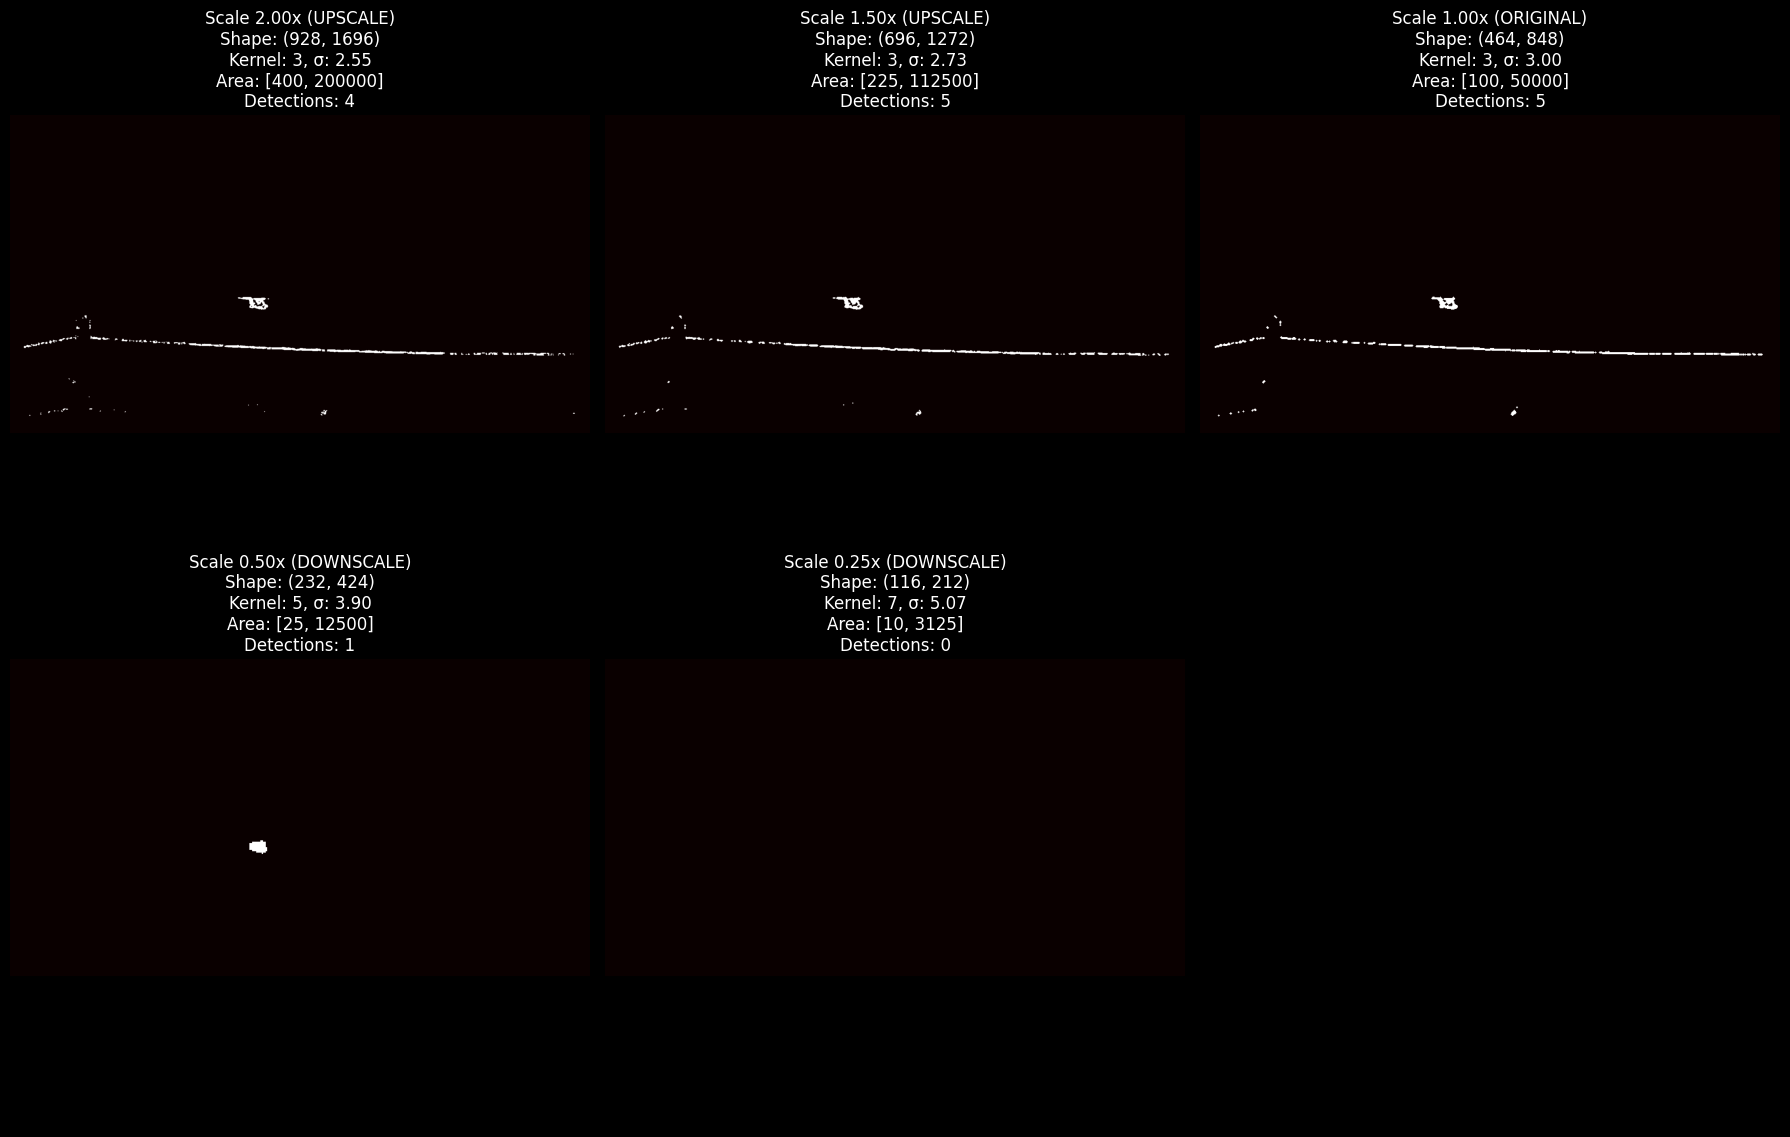

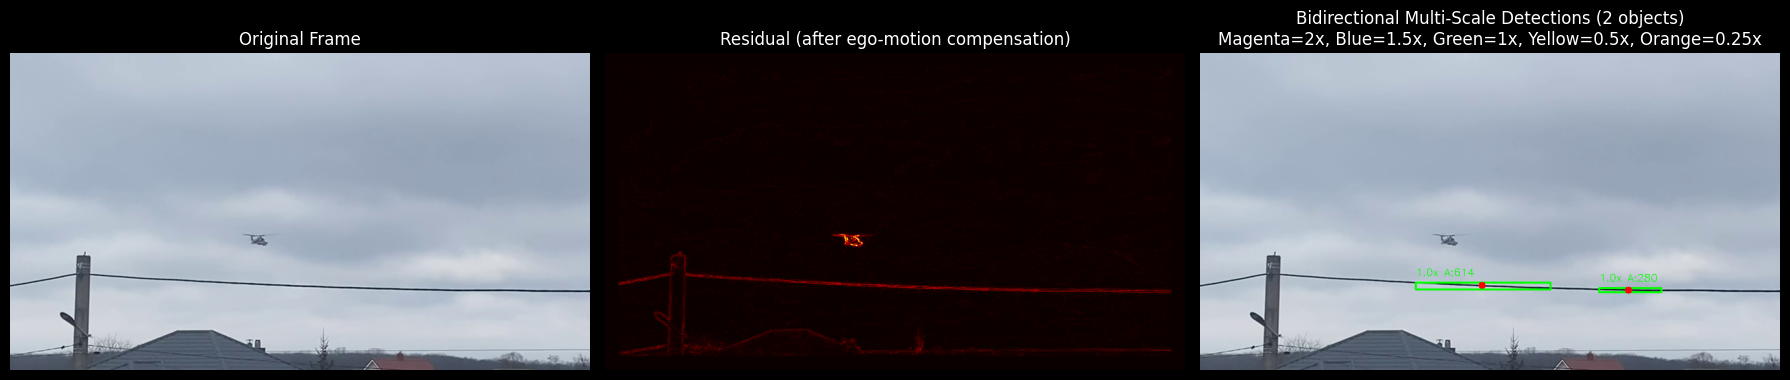

In [9]:
# ============================================
# Visualize pyramid levels for a single frame
# ============================================

def analyze_single_frame(video_path, frame_num=30, 
                         upscale_factors=UPSCALE_FACTORS,
                         num_downscale_levels=NUM_DOWNSCALE_LEVELS):
    """
    Analyze a single frame showing detections at each pyramid level.
    """
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)
    ret, prev_frame = cap.read()
    ret, curr_frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"Cannot read frame {frame_num}")
        return
    
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    
    # Track and estimate motion
    prev_pts = detect_features(prev_gray)
    old_pts, new_pts, _ = track_features(prev_gray, curr_gray, prev_pts)
    
    if old_pts is None or len(old_pts) < 4:
        print("Not enough tracked points")
        return
    
    H, _ = estimate_ego_motion_ransac(old_pts, new_pts)
    
    if H is None:
        print("Could not estimate homography")
        return
    
    # Compute residual
    warped_prev = warp_frame(prev_gray, H)
    valid_mask = create_valid_warp_mask(warped_prev, BORDER_MARGIN)
    residual = compute_residual(curr_gray, warped_prev, valid_mask)
    
    # Bidirectional multi-scale processing
    detections, level_info = process_bidirectional_pyramid(
        residual, valid_mask, upscale_factors, num_downscale_levels
    )
    
    # Visualize
    print(f"\n{'=' * 60}")
    print(f"Frame {frame_num} Analysis - Bidirectional Pyramid")
    print(f"{'=' * 60}")
    print(f"Total detections (after NMS merging): {len(detections)}")
    print(f"\nPer-scale breakdown:")
    for info in level_info:
        scale_type = "UPSCALE" if info['scale'] > 1.0 else ("ORIGINAL" if info['scale'] == 1.0 else "DOWNSCALE")
        print(f"  {info['scale']:.2f}x ({scale_type}): {info['shape']} -> "
              f"{info['detections']} raw detections, "
              f"threshold={info['threshold']:.1f}")
    
    # Show pyramid masks
    visualize_pyramid_levels(level_info, f"{PYRAMID_DIR}/pyramid_frame_{frame_num}.png")
    
    # Show final result
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(cv2.cvtColor(curr_frame, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Frame')
    axes[0].axis('off')
    
    axes[1].imshow(residual, cmap='hot')
    axes[1].set_title('Residual (after ego-motion compensation)')
    axes[1].axis('off')
    
    output = draw_detections(curr_frame, detections)
    axes[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axes[2].set_title(f'Bidirectional Multi-Scale Detections ({len(detections)} objects)\n'
                      'Magenta=2x, Blue=1.5x, Green=1x, Yellow=0.5x, Orange=0.25x')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/analysis_frame_{frame_num}.png", dpi=150)
    plt.show()

# Analyze a specific frame with bidirectional pyramid
analyze_single_frame(VIDEO_PATH, frame_num=30)

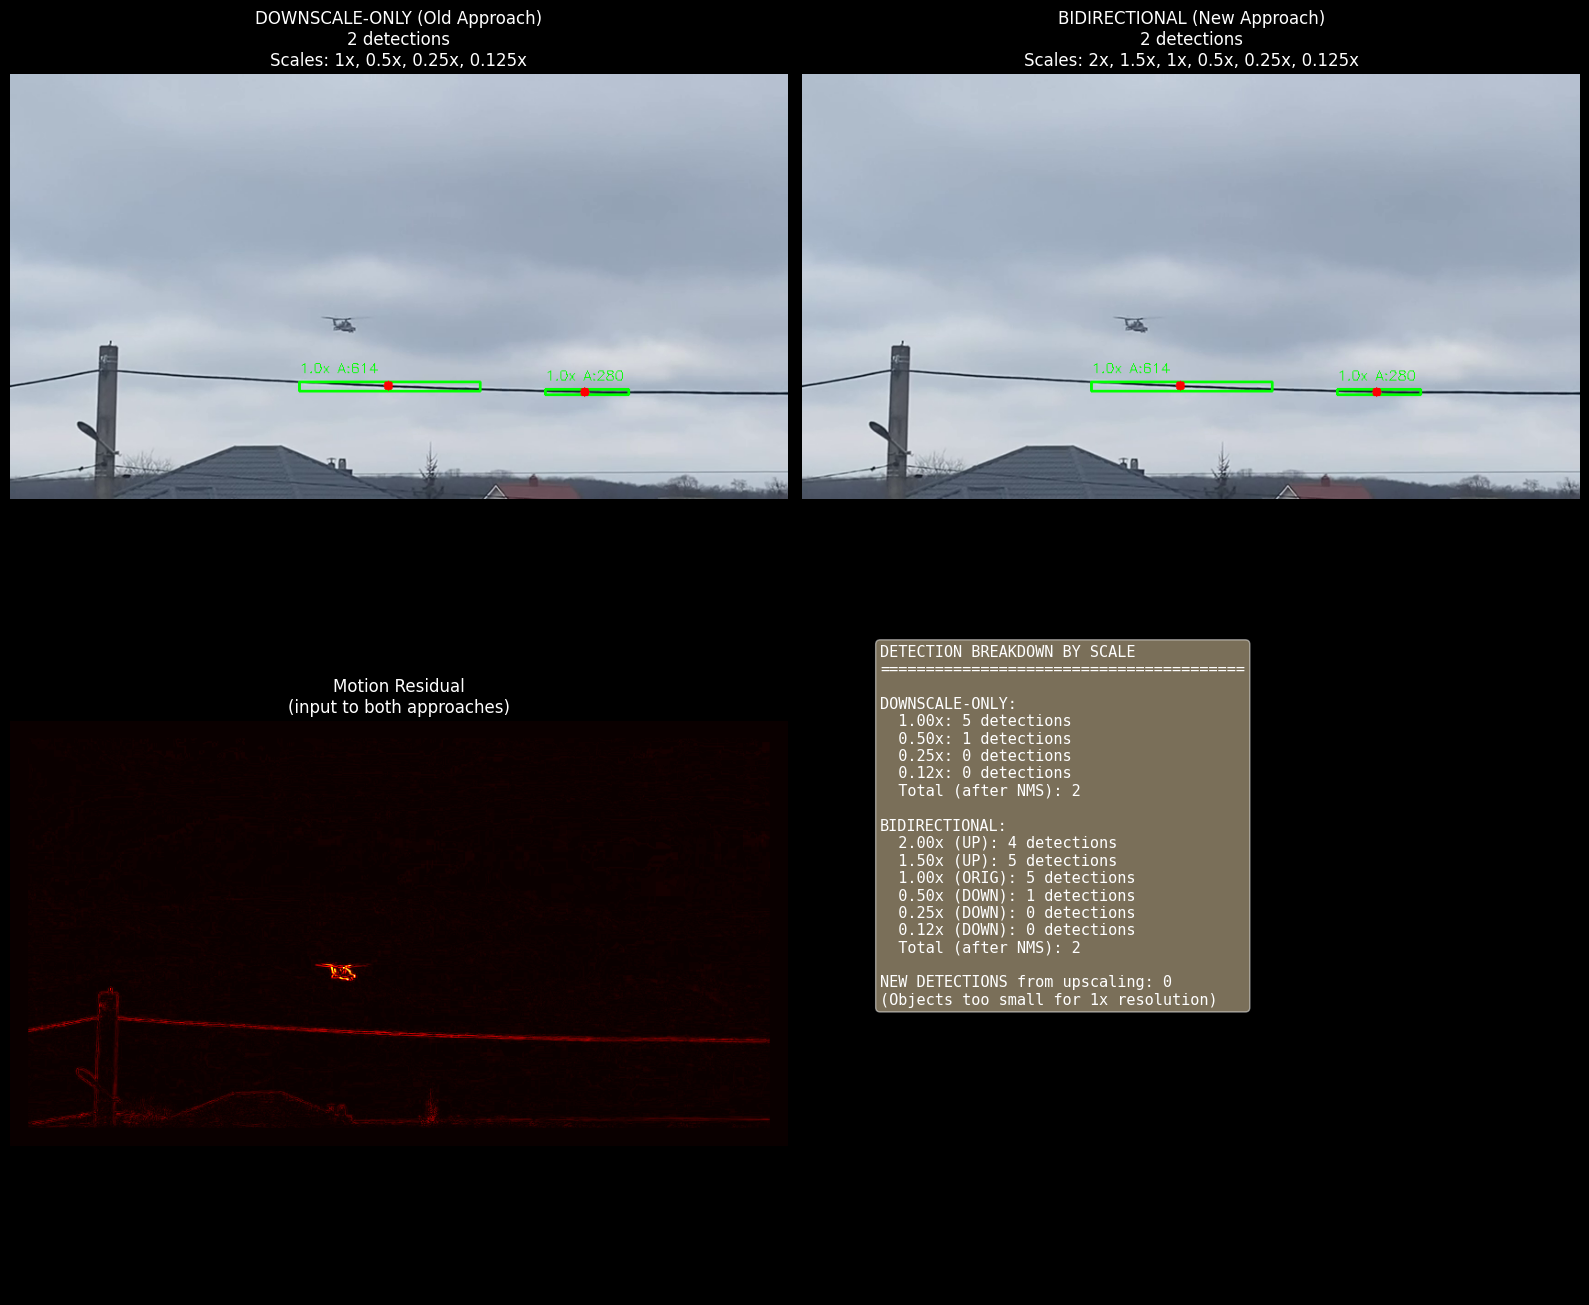


COMPARISON SUMMARY
Downscale-only: 2 detections
Bidirectional:  2 detections
Improvement:    +0 detections

New detections from upscaling: 0


In [10]:
# ============================================
# Compare downscale-only vs bidirectional pyramid
# ============================================

def compare_downscale_vs_bidirectional(video_path, frame_num=30):
    """
    Compare downscale-only (old approach) vs bidirectional (new approach).
    Shows how upscaling helps detect small objects.
    """
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)
    ret, prev_frame = cap.read()
    ret, curr_frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"Cannot read frame {frame_num}")
        return
    
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    
    prev_pts = detect_features(prev_gray)
    old_pts, new_pts, _ = track_features(prev_gray, curr_gray, prev_pts)
    H, _ = estimate_ego_motion_ransac(old_pts, new_pts)
    
    if H is None:
        print("Could not estimate homography")
        return
    
    warped_prev = warp_frame(prev_gray, H)
    valid_mask = create_valid_warp_mask(warped_prev, BORDER_MARGIN)
    residual = compute_residual(curr_gray, warped_prev, valid_mask)
    
    # Downscale-only (old approach) - 1x, 0.5x, 0.25x
    downscale_detections, downscale_info = process_bidirectional_pyramid(
        residual, valid_mask, 
        upscale_factors=[],  # No upscaling
        num_downscale_levels=3
    )
    
    # Bidirectional (new approach) - 2x, 1.5x, 1x, 0.5x, 0.25x
    bidirectional_detections, bidirectional_info = process_bidirectional_pyramid(
        residual, valid_mask,
        upscale_factors=[1.5, 2.0],  # With upscaling
        num_downscale_levels=3
    )
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # Top left: Downscale-only result
    downscale_output = draw_detections(curr_frame, downscale_detections)
    axes[0, 0].imshow(cv2.cvtColor(downscale_output, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title(f'DOWNSCALE-ONLY (Old Approach)\n'
                         f'{len(downscale_detections)} detections\n'
                         f'Scales: 1x, 0.5x, 0.25x, 0.125x')
    axes[0, 0].axis('off')
    
    # Top right: Bidirectional result
    bidirectional_output = draw_detections(curr_frame, bidirectional_detections)
    axes[0, 1].imshow(cv2.cvtColor(bidirectional_output, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title(f'BIDIRECTIONAL (New Approach)\n'
                         f'{len(bidirectional_detections)} detections\n'
                         f'Scales: 2x, 1.5x, 1x, 0.5x, 0.25x, 0.125x')
    axes[0, 1].axis('off')
    
    # Bottom left: Residual
    axes[1, 0].imshow(residual, cmap='hot')
    axes[1, 0].set_title('Motion Residual\n(input to both approaches)')
    axes[1, 0].axis('off')
    
    # Bottom right: Detection counts by scale
    axes[1, 1].axis('off')
    
    # Create comparison text
    comparison_text = "DETECTION BREAKDOWN BY SCALE\n" + "=" * 40 + "\n\n"
    
    comparison_text += "DOWNSCALE-ONLY:\n"
    for info in downscale_info:
        comparison_text += f"  {info['scale']:.2f}x: {info['detections']} detections\n"
    comparison_text += f"  Total (after NMS): {len(downscale_detections)}\n\n"
    
    comparison_text += "BIDIRECTIONAL:\n"
    for info in bidirectional_info:
        scale_type = "UP" if info['scale'] > 1.0 else ("ORIG" if info['scale'] == 1.0 else "DOWN")
        comparison_text += f"  {info['scale']:.2f}x ({scale_type}): {info['detections']} detections\n"
    comparison_text += f"  Total (after NMS): {len(bidirectional_detections)}\n\n"
    
    # Count upscale-only detections
    upscale_only = [d for d in bidirectional_detections if d.get('scale', 1.0) > 1.0]
    comparison_text += f"NEW DETECTIONS from upscaling: {len(upscale_only)}\n"
    comparison_text += "(Objects too small for 1x resolution)"
    
    axes[1, 1].text(0.1, 0.9, comparison_text, transform=axes[1, 1].transAxes,
                    fontsize=11, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/comparison_frame_{frame_num}.png", dpi=150)
    plt.show()
    
    print(f"\n{'=' * 60}")
    print("COMPARISON SUMMARY")
    print(f"{'=' * 60}")
    print(f"Downscale-only: {len(downscale_detections)} detections")
    print(f"Bidirectional:  {len(bidirectional_detections)} detections")
    print(f"Improvement:    +{len(bidirectional_detections) - len(downscale_detections)} detections")
    print(f"\nNew detections from upscaling: {len(upscale_only)}")

# Run comparison
compare_downscale_vs_bidirectional(VIDEO_PATH, frame_num=30)

## How Bidirectional Multi-Scale Pyramid Works

### The Scale Problem
With fixed parameters at original resolution:
- **Very small objects**: Get erased by morphological operations or fall below min area threshold
- **Small objects**: Weak signal, may not pass threshold
- **Large objects**: May exceed max area or get split into multiple detections

### The Solution: Bidirectional Pyramid
Process at multiple resolutions - both **upscaled** (for small objects) and **downscaled** (for large objects):

```
Scale 2.0x   ──► Very small objects (4x area at this scale)
Scale 1.5x   ──► Small objects (2.25x area at this scale)
Scale 1.0x   ──► Medium objects (original resolution)
Scale 0.5x   ──► Large objects (0.25x area at this scale)
Scale 0.25x  ──► Very large objects (0.0625x area at this scale)
```

### Parameter Scaling

| Scale | Type | Kernel | Sigma | Min Area | Max Area | Best For |
|-------|------|--------|-------|----------|----------|----------|
| 2.0x | UPSCALE | 3×3 | 2.55 | 400 px | 200000 px | Very small |
| 1.5x | UPSCALE | 3×3 | 2.72 | 225 px | 112500 px | Small |
| 1.0x | ORIGINAL | 3×3 | 3.00 | 100 px | 50000 px | Medium |
| 0.5x | DOWNSCALE | 5×5 | 3.90 | 25 px | 12500 px | Large |
| 0.25x | DOWNSCALE | 7×7 | 5.07 | 10 px | 3125 px | Very large |

### Why Upscaling Helps Small Objects

At original 1x resolution:
- 5×5 pixel object = 25 px² area → **filtered out** (below 100 px² threshold)
- 3×3 morphological kernel may erase the signal

At 2x upscaled resolution:
- Same object becomes 10×10 pixels = 100 px² area → **detected!**
- Object is now large enough to survive morphological cleanup

### Detection Merging
Objects detected at multiple scales are merged using Non-Maximum Suppression (NMS):
- IoU threshold determines overlap tolerance
- Scoring prefers detections from scales closer to 1.0x (more reliable)
- Prevents duplicate detections of the same object

### Color Coding in Visualizations
- **Magenta**: Detected at 2.0x (upscale - very small objects)
- **Blue**: Detected at 1.5x (upscale - small objects)
- **Green**: Detected at 1.0x (original - medium objects)
- **Yellow**: Detected at 0.5x (downscale - large objects)
- **Orange**: Detected at 0.25x+ (downscale - very large objects)

### Performance Considerations
- Upscaling increases computational cost (2x scale = 4x pixels)
- Consider using fewer upscale levels for real-time applications
- `INTER_CUBIC` interpolation provides good quality/speed balance

---

## DEBUG Mode

Set `DEBUG = True` in the config cell to save all intermediate processing steps.

### Debug Output Structure
When DEBUG is enabled, images are saved to `data/debug_frames/` with this structure:

```
data/debug_frames/
├── frame_0001/
│   ├── 00_COMPOSITE_OVERVIEW.png    # Single image showing all key steps
│   ├── 01_current_frame.png         # Original current frame
│   ├── 02_previous_frame.png        # Previous frame
│   ├── 03_tracked_features.png      # Feature tracking visualization
│   ├── 04_warped_previous.png       # Previous frame warped to align
│   ├── 05_valid_mask.png            # Valid pixel mask after warping
│   ├── 06_residual_gray.png         # Grayscale residual
│   ├── 07_residual_heatmap.png      # Residual as heatmap
│   ├── 08_final_detections.png      # Final detections on frame
│   ├── summary.txt                  # Text summary of processing
│   │
│   ├── scale_2.00x/                 # Per-scale debug images
│   │   ├── 1_residual_scaled.png    # Residual at this scale
│   │   ├── 2_valid_mask.png         # Valid mask at this scale
│   │   ├── 3_threshold_mask_raw.png # Raw threshold (before morphology)
│   │   ├── 4_motion_mask_morph.png  # After morphological cleanup
│   │   ├── 5_detections.png         # Detections at this scale
│   │   └── params.txt               # Parameters used at this scale
│   │
│   ├── scale_1.50x/
│   ├── scale_1.00x/
│   ├── scale_0.50x/
│   └── scale_0.25x/
│
├── frame_0002/
...
```

### Tracked Features Visualization
- **Green arrows**: Inliers (points following background motion)
- **Red arrows**: Outliers (potential moving objects)

### Using Debug Output
1. Check `00_COMPOSITE_OVERVIEW.png` for quick overview of each frame
2. Compare `3_threshold_mask_raw.png` vs `4_motion_mask_morph.png` to see morphology effect
3. Review `params.txt` to understand parameters used at each scale
4. Use `summary.txt` for detection counts and scale breakdown